# Model Training Notebook for LSTM Model

This notebook is dedicated to training an LSTM model focusing on longitudinal predictions in Alzheimer's disease progression. More specifically, the model is capable of predicting future regional tau concentrations across 86 brain regions, as well as predict baseline cognition. this is done through the use of regional biomarker data derived from tau PET along with demographic data. This notebook covers:

### Data Preprocessing 
- Loading 
- Normalization
- Formatting
- Splitting

### Model Training
- Data conversion into tensors and datasets 
- K-fold cross validation 
- Training
- Loss curve plotting

### Model Analysis
- Correlation analysis 
- Prediction accuracy 

## Data Preprocessing

In [6]:
import sys
sys.path.append('../')
import pandas as pd 
import numpy as np
import mat4py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from model import LSTMwithStatic


In [7]:
lap_path = '../data/Lap.mat'
lap = mat4py.loadmat(lap_path)

# load data
path = '../data/endm_data.mat'
data = mat4py.loadmat(path)

In [8]:
ad = data['pred_ad']
emci = data['pred_emci']
lmci = data['pred_lmci']

In [9]:
# combine into one dataset
ad = pd.DataFrame(ad)
emci = pd.DataFrame(emci)
lmci = pd.DataFrame(lmci)

data = pd.concat([ad, emci, lmci], axis=0).reset_index(drop=True)
data

,pid,dx,params_opt,bestseed,tsol,xsol,fsol,xpred,fpred,Rmax_tau,Rmax_abeta,tmax
0,112,AD,"[0.23839086467526235, 0.0636251316936558, 0.83...",5,"[[0.0], [0.1642486554715465], [0.3284973109430...","[[0.0, 1.5154876748982818e-10, 9.7067880966823...","[[0.0, 0.0002763638728445425, 0.00109288670575...","[[1.0004933114536538], [1.0005031548543686], [...","[[1.5049445394023468], [0.6595554006015238], [...",0.355204,0.743335,28.926362
1,142,AD,"[0.11841479166912611, 1.0122917613402689, 0.76...",5,"[[0.0], [0.07470103876846185], [0.149402077536...","[[0.0, 6.320626952342735e-13, 7.79590773551454...","[[0.0, 5.5644473855306635e-05, 0.0002206290362...","[[0.4196941407933126], [0.2859456443023018], [...","[[1.0720760355524686], [0.9762340290611295], [...",0.205701,0.483308,18.016251
2,416,AD,"[0.23092519980143342, 0.6517723682511173, 0.84...",5,"[[0.0], [0.10357972410129937], [0.207159448202...","[[0.0, 1.5549218134933345e-11, 1.3265144894746...","[[0.0, 8.441872940513956e-05, 0.00033421851525...","[[0.9997945047295864], [0.9986231068180185], [...","[[1.0405218367594613], [0.9907213596716922], [...",0.361411,0.482275,30.000000
3,626,AD,"[0.049300916349889055, 0.7793420088723634, 0.8...",5,"[[0.0], [0.09753022891752935], [0.195060457835...","[[0.0, 3.0984956182799324e-13, 4.3213354288096...","[[0.0, 0.00010696482813588273, 0.0004234588733...","[[0.3965052881537961], [0.3913854024831684], [...","[[1.0929183536912621], [0.9689540310541643], [...",0.616567,0.363728,18.344281
4,896,AD,"[0.12579467871663205, 0.20838354253070115, 0.0...",5,"[[0.0], [0.3137012319450042], [0.6274024638900...","[[0.0, 3.0176955277484626e-13, 1.8588172333738...","[[0.0, 0.0010747624076023223, 0.00419657690172...","[[0.7685743641539413], [0.3248973535554547], [...","[[1.3363053727478946], [0.8206612037752417], [...",0.599344,-0.365623,19.090763
...,...,...,...,...,...,...,...,...,...,...,...,...
191,6606,LMCI,"[0.024783288216221284, 0.1853454899449769, 0.6...",5,"[[0.0], [0.3685880456005913], [0.7371760912011...","[[0.0, 1.487141624971677e-11, 1.73003944730773...","[[0.0, 0.0009596659162232945, 0.00373302141039...","[[0.8168989945351371], [0.7555964137369207], [...","[[1.1976843318805857], [0.9309189658638678], [...",0.774367,0.733608,30.000000
192,6632,LMCI,"[0.31387862558678364, 1.1162684409127184, 0.03...",5,"[[0.0], [0.11864896124059698], [0.237297922481...","[[0.0, 3.2286433106663908e-12, 2.1390054569148...","[[0.0, 0.00011437110975240852, 0.0004506565902...","[[0.9992312430436467], [0.9971949209318182], [...","[[1.0221585129440451], [0.9938153124163946], [...",0.474219,-0.025849,30.000000
193,6634,LMCI,"[0.18506847582756658, 1.968312112172487, 0.811...",5,"[[0.0], [0.08502115067896504], [0.170042301357...","[[0.0, 3.445735874145771e-12, 3.54441244207998...","[[0.0, 4.929630006857729e-05, 0.00019420837498...","[[0.9932082448004274], [0.9575956972292802], [...","[[1.0121562052403392], [0.9963208082442878], [...",0.680151,0.181257,30.000000
194,6641,LMCI,"[0.2826925905252355, 0.5802431533350701, 0.552...",5,"[[0.0], [0.10794464143154661], [0.215889282863...","[[0.0, 2.1434095037216448e-11, 1.6025587426862...","[[0.0, 7.485870770284761e-05, 0.00029635960911...","[[0.9886228867313394], [0.9583042561670181], [...","[[1.0465274532728208], [0.9897512305267303], [...",0.627936,0.684156,30.000000


In [12]:
# Merge with demographic data
demo = pd.read_csv('../data/demo.csv')
data = pd.merge(data, demo, left_on='pid', right_on='RID')

In [13]:
# check which columns have nan values
data.isnull().sum()

pid             0
dx              0
params_opt      0
bestseed        0
tsol            0
xsol            0
fsol            0
xpred           0
fpred           0
Rmax_tau        0
Rmax_abeta      0
tmax            0
RID             0
DX_bl           0
AGE             1
PTGENDER        0
PTEDUCAT        0
PTMARRY         0
ADAS11_bl       1
APOE4           0
MMSE_bl         0
MOCA_bl        31
ABETA_bl       61
TAU_bl         61
PTAU_bl        61
FDG_bl         18
PIB_bl        193
AV45_bl        30
dtype: int64

In [14]:
# drop data that has NaN age and ADAS11_bl, as we are interested in these 
data = data.dropna(subset=['AGE', 'ADAS11_bl'])

In [15]:
# drop columns that have NaN values
data = data.dropna(axis=1)
data = data.drop(columns=['RID'])

In [16]:
# drop columns that have nan values
data = data.dropna(axis=1)

In [17]:
# drop columns that we're not interested in 
data.drop(columns=['dx', 'params_opt', 'bestseed', 'tsol', 'fsol', 'xpred', 'fpred', 'Rmax_tau', 'Rmax_abeta', 'tmax'], inplace=True)

In [18]:
data

,pid,xsol,DX_bl,AGE,PTGENDER,PTEDUCAT,PTMARRY,ADAS11_bl,APOE4,MMSE_bl
0,112,"[[0.0, 1.5154876748982818e-10, 9.7067880966823...",LMCI,70.6,Male,18,Married,6.00,1.0,30
1,142,"[[0.0, 6.320626952342735e-13, 7.79590773551454...",LMCI,79.2,Male,14,Widowed,7.33,1.0,29
2,416,"[[0.0, 1.5549218134933345e-11, 1.3265144894746...",CN,75.6,Female,14,Married,3.00,0.0,29
3,626,"[[0.0, 3.0984956182799324e-13, 4.3213354288096...",LMCI,83.2,Male,16,Married,11.67,0.0,25
4,896,"[[0.0, 3.0176955277484626e-13, 1.8588172333738...",CN,76.8,Male,16,Married,2.00,0.0,30
...,...,...,...,...,...,...,...,...,...,...
191,6606,"[[0.0, 1.487141624971677e-11, 1.73003944730773...",LMCI,73.6,Female,16,Married,14.67,1.0,26
192,6632,"[[0.0, 3.2286433106663908e-12, 2.1390054569148...",LMCI,74.5,Female,14,Married,23.00,1.0,22
193,6634,"[[0.0, 3.445735874145771e-12, 3.54441244207998...",LMCI,80.3,Female,16,Married,16.33,0.0,28
194,6641,"[[0.0, 2.1434095037216448e-11, 1.6025587426862...",LMCI,64.9,Male,16,Married,10.67,1.0,29


In [19]:
# randomly sample 20% of data to use as test set, set random state to 42 for reproducibility 
data, test = train_test_split(data, test_size=0.2, random_state=42)

In [20]:
def split_timepoints(patient_data):
    """
    Split the timepoints of a patient's data into sequences of 10 timepoints with the 11th as the output.

    Params
    ------
    patient_data : dict
        A dictionary containing the patient's data. The 'xsol' key should contain the patient's timepoints.

    Returns
    -------
    sequences : list
        A list of tuples where the first element is a sequence of 10 timepoints and the second element is the output.

    """
    sequences = []
    xsol = patient_data['xsol']  
    xsol = np.array(xsol)
    T = xsol.shape[1]  

    # calculate the number of complete non-overlapping sequences we can create
    num_sequences = T // 11
    
    # create non-overlapping sequences of 10 timepoints with the 11th as the output
    for seq_idx in range(num_sequences):
        start_idx = seq_idx * 11
        end_idx = start_idx + 10
        input_sequence = xsol[:, start_idx:end_idx]
        output_value = xsol[:, end_idx]
        sequences.append((input_sequence, output_value))
    
    return sequences

# New DataFrame to hold the transformed dataset
transformed_data = []

# iterate over each patient's data
for index, row in data.iterrows():
    patient_sequences = split_timepoints(row)
    
    for input_sequence, output_value in patient_sequences:
        new_row = row.to_dict() 
        new_row['xsol'] = input_sequence 
        new_row['output'] = output_value  
        transformed_data.append(new_row)

# create the new DataFrame from the transformed data
transformed_df = pd.DataFrame(transformed_data)

In [21]:
# repeat with test data
transformed_test_data = []

# Iterate over each patient's data
for index, row in test.iterrows():
    patient_sequences = split_timepoints(row)
    
    for input_sequence, output_value in patient_sequences:
        new_row = row.to_dict() 
        new_row['xsol'] = input_sequence 
        new_row['output'] = output_value  
        transformed_test_data.append(new_row)

# Create the new DataFrame from the transformed data
transformed_test_df = pd.DataFrame(transformed_test_data)


In [22]:
transformed_df

,pid,xsol,DX_bl,AGE,PTGENDER,PTEDUCAT,PTMARRY,ADAS11_bl,APOE4,MMSE_bl,output
0,925,"[[0.0, 2.963922129042131e-12, 3.17677135859176...",LMCI,74.4,Male,12,Married,16.33,0.0,29,"[2.283406521311905e-08, 2.606101547563823e-07,..."
1,925,"[[3.533871692129039e-08, 5.244407829059746e-08...",LMCI,74.4,Male,12,Married,16.33,0.0,29,"[2.2737409361114515e-06, 7.800639678818644e-06..."
2,925,"[[3.213328555393013e-06, 4.423317434746615e-06...",LMCI,74.4,Male,12,Married,16.33,0.0,29,"[5.058023454461953e-05, 8.039333551893796e-05,..."
3,925,"[[6.44718296005434e-05, 8.127642988299988e-05,...",LMCI,74.4,Male,12,Married,16.33,0.0,29,"[0.000542932412157601, 0.0005392992768158535, ..."
4,925,"[[0.0006605197160317743, 0.0008090570215333427...",LMCI,74.4,Male,12,Married,16.33,0.0,29,"[0.0044892020198790735, 0.0034390119613225568,..."
...,...,...,...,...,...,...,...,...,...,...,...
1149,4301,"[[1.3573852695453507e-09, 2.3119704601509383e-...",EMCI,74.6,Male,18,Married,7.00,0.0,28,"[1.8433493782827617e-07, 1.4482799665677942e-0..."
1150,4301,"[[2.915942398450143e-07, 4.6189151073551194e-0...",EMCI,74.6,Male,18,Married,7.00,0.0,28,"[2.0142656305482933e-05, 0.0008213380175598269..."
1151,4301,"[[2.980813277307056e-05, 4.179606507813579e-05...",EMCI,74.6,Male,18,Married,7.00,0.0,28,"[0.0007205697275158808, 0.022381417526841262, ..."
1152,4301,"[[0.0009656809222559064, 0.0012972157389788742...",EMCI,74.6,Male,18,Married,7.00,0.0,28,"[0.016618794570432385, 0.435422249143586, 0.02..."


In [23]:
transformed_test_df

,pid,xsol,DX_bl,AGE,PTGENDER,PTEDUCAT,PTMARRY,ADAS11_bl,APOE4,MMSE_bl,output
0,6297,"[[0.0, 1.4802467276302817e-16, 2.4259220558544...",EMCI,81.4,Male,20,Married,3.33,0.0,30,"[2.3397592837335382e-12, 2.6599893965619316e-0..."
1,6297,"[[3.997378641386e-12, 6.408548705754264e-12, 1...",EMCI,81.4,Male,20,Married,3.33,0.0,30,"[4.0452631280450805e-10, 1.1890875041951702e-0..."
2,6297,"[[7.167150781653375e-10, 1.2242495406116358e-0...",EMCI,81.4,Male,20,Married,3.33,0.0,30,"[1.2392222923335165e-07, 1.0029819028895022e-0..."
3,6297,"[[2.0018591261052426e-07, 3.23569867980225e-07...",EMCI,81.4,Male,20,Married,3.33,0.0,30,"[1.525015317675765e-05, 0.0006561985377797931,..."
4,6297,"[[2.2584961955251457e-05, 3.1646936172887816e-...",EMCI,81.4,Male,20,Married,3.33,0.0,30,"[0.0005454685062830125, 0.01805541291913366, 0..."
...,...,...,...,...,...,...,...,...,...,...,...
290,2238,"[[5.551551400003103e-10, 9.062458642814374e-10...",EMCI,68.5,Male,18,Married,5.00,0.0,29,"[4.203023966098193e-08, 5.342082989949264e-06,..."
291,2238,"[[6.689670527355568e-08, 1.0637169170787036e-0...",EMCI,68.5,Male,18,Married,5.00,0.0,29,"[5.201532920623629e-06, 0.00030768278642774176..."
292,2238,"[[7.844003390566658e-06, 1.1307583733443278e-0...",EMCI,68.5,Male,18,Married,5.00,0.0,29,"[0.00025051763892808705, 0.010666485462631384,..."
293,2238,"[[0.0003417828462267505, 0.0004677035695311112...",EMCI,68.5,Male,18,Married,5.00,0.0,29,"[0.006497273279096986, 0.2330397092716891, 0.0..."


#### We use the Laplacian of the connectome to perform dimensionality reduction. More specifically, we use the top-8 eigenvectors of the Laplacian.

In [24]:
lap = pd.DataFrame(lap)

In [25]:
# sort pd by evalues 
lap = lap.sort_values(by='evalues_ret', ascending=False)
lap

,Cret,Lret,evalues_ret,evecs_ret
85,"[0.4687499999999998, 0.26249999999999907, 1.59...","[-0.0006139598190908734, -0.000343817498690888...",[1.3794917906837714],"[-0.10783277320343844, -0.09382186127949262, -..."
84,"[0.0, 3.3062499999999986, 0.0, 0.0312499999999...","[0.0, -0.023611897182462375, 0.0, -0.000223174...",[1.3764479274341213],"[-0.10783277320343841, -0.08232163323976788, 0..."
83,"[0.0, 0.0, 0.0, 0.0, 22.4564999999996, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, -0.16093494412802048, 0.0...",[1.3706869248490714],"[-0.10783277320343836, -0.1605455365140007, -0..."
82,"[0.17499999999999977, 0.0, 0.18749999999999833...","[-0.00035232252929027845, 0.0, -0.000377488424...",[1.3451603780112253],"[-0.1078327732034385, -0.15555154245004005, -0..."
81,"[0.2437499999999997, 0.17499999999999843, 0.52...","[-0.0006342437402064888, -0.000455354480148244...",[1.3158437467160933],"[-0.10783277320343843, -0.10016460920282916, 0..."
...,...,...,...,...
4,"[0.0, 0.0687499999999999, 0.0, 0.0999999999999...","[0.0, -0.0006313435679865206, 0.0, -0.00091831...",[0.46787383318830317],"[-0.10783277320343825, -0.19320628709361612, -..."
3,"[0.26874999999999993, 0.012499999999999928, 0....","[-0.0007007001228141448, -3.2590703386704226e-...",[0.43258948444839596],"[-0.10783277320343866, -0.1259531031344173, -0..."
2,"[0.29999999999999993, 0.26249999999999973, 0.0...","[-0.0004643109824486952, -0.000406272109642608...",[0.34406805713071553],"[-0.10783277320343851, -0.044786548601004846, ..."
1,"[0.04374999999999992, 0.0, 0.26249999999999973...","[-0.00013572310532502512, 1.0, -0.000814338631...",[0.1811289857715289],"[-0.10783277320343834, -0.06571109974951013, 0..."


In [26]:
# select top 8 eigenvectors 
k = 8
lap_topk = lap.iloc[:k, :]
lap_topk

,Cret,Lret,evalues_ret,evecs_ret
85,"[0.4687499999999998, 0.26249999999999907, 1.59...","[-0.0006139598190908734, -0.000343817498690888...",[1.3794917906837714],"[-0.10783277320343844, -0.09382186127949262, -..."
84,"[0.0, 3.3062499999999986, 0.0, 0.0312499999999...","[0.0, -0.023611897182462375, 0.0, -0.000223174...",[1.3764479274341213],"[-0.10783277320343841, -0.08232163323976788, 0..."
83,"[0.0, 0.0, 0.0, 0.0, 22.4564999999996, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, -0.16093494412802048, 0.0...",[1.3706869248490714],"[-0.10783277320343836, -0.1605455365140007, -0..."
82,"[0.17499999999999977, 0.0, 0.18749999999999833...","[-0.00035232252929027845, 0.0, -0.000377488424...",[1.3451603780112253],"[-0.1078327732034385, -0.15555154245004005, -0..."
81,"[0.2437499999999997, 0.17499999999999843, 0.52...","[-0.0006342437402064888, -0.000455354480148244...",[1.3158437467160933],"[-0.10783277320343843, -0.10016460920282916, 0..."
80,"[2.993749999999999, 2.5999999999999988, 5.294,...","[-0.0020904767803872296, -0.001815528894866570...",[1.3004267454728649],"[-0.1078327732034384, -0.11365876394345624, 0...."
79,"[0.1812499999999984, 1.8937499999999998, 21.38...","[-0.00028463990756448276, -0.00297399627558755...",[1.2911965955351816],"[-0.10783277320343837, -0.07039008870697731, 0..."
78,"[0.8124999999999997, 1.9499999999999997, 5.275...","[-0.0009784975235891695, -0.002348394056614007...",[1.2889386412690411],"[-0.10783277320343855, -0.10019043917244076, 0..."


In [27]:
# make matrix of top k eigenvectors
evecs = lap_topk['evecs_ret'].values
evecs = np.array([np.array(evec) for evec in evecs])
evecs.shape

(8, 86)

In [28]:
# extract tau values 
tau = transformed_df['xsol'].values
tau_test = transformed_test_df['xsol'].values

In [29]:
# convert each list to a numpy array
for i in range(len(tau)):
    tau[i] = np.array(tau[i])

for i in range(len(tau_test)):
    tau_test[i] = np.array(tau_test[i])

In [30]:
# reduce dimensionality of tau and ab
for i in range(len(tau)):
    tau[i] = np.dot(evecs, tau[i])

for i in range(len(tau_test)):
    tau_test[i] = np.dot(evecs, tau_test[i])


# place back into dataframe
transformed_df['xsol'] = tau
transformed_test_df['xsol'] = tau_test



In [31]:
# one hot encode DX_bl, PTGENDER, PTMARRY as 0 or 1
transformed_df = pd.get_dummies(transformed_df, columns=['DX_bl', 'PTGENDER', 'PTMARRY'])

# convert each to 0 or 1
transformed_df['DX_bl_AD'] = transformed_df['DX_bl_AD'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['DX_bl_CN'] = transformed_df['DX_bl_CN'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['DX_bl_EMCI'] = transformed_df['DX_bl_EMCI'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['DX_bl_LMCI'] = transformed_df['DX_bl_LMCI'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['DX_bl_SMC'] = transformed_df['DX_bl_SMC'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTGENDER_Female'] = transformed_df['PTGENDER_Female'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTGENDER_Male'] = transformed_df['PTGENDER_Male'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTMARRY_Divorced'] = transformed_df['PTMARRY_Divorced'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTMARRY_Married'] = transformed_df['PTMARRY_Married'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTMARRY_Never married'] = transformed_df['PTMARRY_Never married'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTMARRY_Unknown'] = transformed_df['PTMARRY_Unknown'].apply(lambda x: 1 if x == 1 else 0)
transformed_df['PTMARRY_Widowed'] = transformed_df['PTMARRY_Widowed'].apply(lambda x: 1 if x == 1 else 0)


transformed_df

,pid,xsol,AGE,PTEDUCAT,ADAS11_bl,APOE4,MMSE_bl,output,DX_bl_AD,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
0,925,"[[0.0, -3.7711692645167776e-05, -0.00014923516...",74.4,12,16.33,0.0,29,"[2.283406521311905e-08, 2.606101547563823e-07,...",0,0,0,1,0,0,1,0,1,0,0,0
1,925,"[[-0.004473217343817407, -0.005363855786127356...",74.4,12,16.33,0.0,29,"[2.2737409361114515e-06, 7.800639678818644e-06...",0,0,0,1,0,0,1,0,1,0,0,0
2,925,"[[-0.03190170336979194, -0.03623244527376353, ...",74.4,12,16.33,0.0,29,"[5.058023454461953e-05, 8.039333551893796e-05,...",0,0,0,1,0,0,1,0,1,0,0,0
3,925,"[[-0.09640746255597844, -0.10408313494656503, ...",74.4,12,16.33,0.0,29,"[0.000542932412157601, 0.0005392992768158535, ...",0,0,0,1,0,0,1,0,1,0,0,0
4,925,"[[-0.1975461521385021, -0.2093360448290355, -0...",74.4,12,16.33,0.0,29,"[0.0044892020198790735, 0.0034390119613225568,...",0,0,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,4301,"[[-0.08941921379316167, -0.11136037684968782, ...",74.6,18,7.00,0.0,28,"[1.8433493782827617e-07, 1.4482799665677942e-0...",0,0,1,0,0,0,1,0,1,0,0,0
1150,4301,"[[-0.6814270864077985, -0.7850001226546155, -0...",74.6,18,7.00,0.0,28,"[2.0142656305482933e-05, 0.0008213380175598269...",0,0,1,0,0,0,1,0,1,0,0,0
1151,4301,"[[-1.5286946280044704, -1.5498954287238536, -1...",74.6,18,7.00,0.0,28,"[0.0007205697275158808, 0.022381417526841262, ...",0,0,1,0,0,0,1,0,1,0,0,0
1152,4301,"[[-1.4571087825075406, -1.415805331156342, -1....",74.6,18,7.00,0.0,28,"[0.016618794570432385, 0.435422249143586, 0.02...",0,0,1,0,0,0,1,0,1,0,0,0


#### One hot encoding 

In [32]:
# one hot encode DX_bl, PTGENDER, PTMARRY as 0 or 1
transformed_test_df = pd.get_dummies(transformed_test_df, columns=['DX_bl', 'PTGENDER', 'PTMARRY'])

# convert each to 0 or 1
transformed_test_df['DX_bl_AD'] = transformed_test_df['DX_bl_AD'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['DX_bl_CN'] = transformed_test_df['DX_bl_CN'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['DX_bl_EMCI'] = transformed_test_df['DX_bl_EMCI'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['DX_bl_LMCI'] = transformed_test_df['DX_bl_LMCI'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['PTGENDER_Female'] = transformed_test_df['PTGENDER_Female'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['PTGENDER_Male'] = transformed_test_df['PTGENDER_Male'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['PTMARRY_Divorced'] = transformed_test_df['PTMARRY_Divorced'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['PTMARRY_Married'] = transformed_test_df['PTMARRY_Married'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['PTMARRY_Never married'] = transformed_test_df['PTMARRY_Never married'].apply(lambda x: 1 if x == 1 else 0)
transformed_test_df['PTMARRY_Widowed'] = transformed_test_df['PTMARRY_Widowed'].apply(lambda x: 1 if x == 1 else 0)

transformed_test_df


,pid,xsol,AGE,PTEDUCAT,ADAS11_bl,APOE4,MMSE_bl,output,DX_bl_AD,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,PTGENDER_Female,PTGENDER_Male,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Widowed
0,6297,"[[0.0, -3.3161198729595785e-05, -0.00013152764...",81.4,20,3.33,0.0,30,"[2.3397592837335382e-12, 2.6599893965619316e-0...",0,0,1,0,0,1,0,1,0,0
1,6297,"[[-0.004995075984721715, -0.006258160972662441...",81.4,20,3.33,0.0,30,"[4.0452631280450805e-10, 1.1890875041951702e-0...",0,0,1,0,0,1,0,1,0,0
2,6297,"[[-0.05231199976704926, -0.06532126015672982, ...",81.4,20,3.33,0.0,30,"[1.2392222923335165e-07, 1.0029819028895022e-0...",0,0,1,0,0,1,0,1,0,0
3,6297,"[[-0.4920670845035451, -0.5857651400704482, -0...",81.4,20,3.33,0.0,30,"[1.525015317675765e-05, 0.0006561985377797931,...",0,0,1,0,0,1,0,1,0,0
4,6297,"[[-1.4446982208327825, -1.4783956164161733, -1...",81.4,20,3.33,0.0,30,"[0.0005454685062830125, 0.01805541291913366, 0...",0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2238,"[[-0.08430370972841328, -0.10391948491787971, ...",68.5,18,5.00,0.0,29,"[4.203023966098193e-08, 5.342082989949264e-06,...",0,0,1,0,0,1,0,1,0,0
291,2238,"[[-0.570299335768688, -0.6706749021352174, -0....",68.5,18,5.00,0.0,29,"[5.201532920623629e-06, 0.00030768278642774176...",0,0,1,0,0,1,0,1,0,0
292,2238,"[[-1.5326570301473594, -1.561958601977828, -1....",68.5,18,5.00,0.0,29,"[0.00025051763892808705, 0.010666485462631384,...",0,0,1,0,0,1,0,1,0,0
293,2238,"[[-1.5491971624006058, -1.51849426147535, -1.4...",68.5,18,5.00,0.0,29,"[0.006497273279096986, 0.2330397092716891, 0.0...",0,0,1,0,0,1,0,1,0,0


#### Normalize numerical values

In [33]:
# normalize AGE, PTEDUCAT, ADAS11_bl, MMSE_bl
adas_std = transformed_df['ADAS11_bl'].std()
adas_mean = transformed_df['ADAS11_bl'].mean()
mmse_std = transformed_df['MMSE_bl'].std()
mmse_mean = transformed_df['MMSE_bl'].mean()
age_std = transformed_df['AGE'].std()
age_mean = transformed_df['AGE'].mean()
educ_std = transformed_df['PTEDUCAT'].std()
educ_mean = transformed_df['PTEDUCAT'].mean()


transformed_df['AGE'] = (transformed_df['AGE'] - transformed_df['AGE'].mean()) / transformed_df['AGE'].std()
transformed_df['PTEDUCAT'] = (transformed_df['PTEDUCAT'] - transformed_df['PTEDUCAT'].mean()) / transformed_df['PTEDUCAT'].std()
transformed_df['ADAS11_bl'] = (transformed_df['ADAS11_bl'] - transformed_df['ADAS11_bl'].mean()) / transformed_df['ADAS11_bl'].std()
transformed_df['MMSE_bl'] = (transformed_df['MMSE_bl'] - transformed_df['MMSE_bl'].mean()) / transformed_df['MMSE_bl'].std()
transformed_df


,pid,xsol,AGE,PTEDUCAT,ADAS11_bl,APOE4,MMSE_bl,output,DX_bl_AD,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
0,925,"[[0.0, -3.7711692645167776e-05, -0.00014923516...",0.354570,-1.505813,1.325243,0.0,0.481836,"[2.283406521311905e-08, 2.606101547563823e-07,...",0,0,0,1,0,0,1,0,1,0,0,0
1,925,"[[-0.004473217343817407, -0.005363855786127356...",0.354570,-1.505813,1.325243,0.0,0.481836,"[2.2737409361114515e-06, 7.800639678818644e-06...",0,0,0,1,0,0,1,0,1,0,0,0
2,925,"[[-0.03190170336979194, -0.03623244527376353, ...",0.354570,-1.505813,1.325243,0.0,0.481836,"[5.058023454461953e-05, 8.039333551893796e-05,...",0,0,0,1,0,0,1,0,1,0,0,0
3,925,"[[-0.09640746255597844, -0.10408313494656503, ...",0.354570,-1.505813,1.325243,0.0,0.481836,"[0.000542932412157601, 0.0005392992768158535, ...",0,0,0,1,0,0,1,0,1,0,0,0
4,925,"[[-0.1975461521385021, -0.2093360448290355, -0...",0.354570,-1.505813,1.325243,0.0,0.481836,"[0.0044892020198790735, 0.0034390119613225568,...",0,0,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,4301,"[[-0.08941921379316167, -0.11136037684968782, ...",0.382865,0.700801,-0.485325,0.0,0.084097,"[1.8433493782827617e-07, 1.4482799665677942e-0...",0,0,1,0,0,0,1,0,1,0,0,0
1150,4301,"[[-0.6814270864077985, -0.7850001226546155, -0...",0.382865,0.700801,-0.485325,0.0,0.084097,"[2.0142656305482933e-05, 0.0008213380175598269...",0,0,1,0,0,0,1,0,1,0,0,0
1151,4301,"[[-1.5286946280044704, -1.5498954287238536, -1...",0.382865,0.700801,-0.485325,0.0,0.084097,"[0.0007205697275158808, 0.022381417526841262, ...",0,0,1,0,0,0,1,0,1,0,0,0
1152,4301,"[[-1.4571087825075406, -1.415805331156342, -1....",0.382865,0.700801,-0.485325,0.0,0.084097,"[0.016618794570432385, 0.435422249143586, 0.02...",0,0,1,0,0,0,1,0,1,0,0,0


In [34]:
transformed_test_df['AGE'] = (transformed_test_df['AGE'] - age_mean) / age_std
transformed_test_df['PTEDUCAT'] = (transformed_test_df['PTEDUCAT'] - educ_mean) / educ_std
transformed_test_df['ADAS11_bl'] = (transformed_test_df['ADAS11_bl'] - adas_mean) / adas_std
transformed_test_df['MMSE_bl'] = (transformed_test_df['MMSE_bl'] - mmse_mean) / mmse_std

transformed_test_df

,pid,xsol,AGE,PTEDUCAT,ADAS11_bl,APOE4,MMSE_bl,output,DX_bl_AD,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,PTGENDER_Female,PTGENDER_Male,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Widowed
0,6297,"[[0.0, -3.3161198729595785e-05, -0.00013152764...",1.344895,1.436338,-1.197521,0.0,0.879576,"[2.3397592837335382e-12, 2.6599893965619316e-0...",0,0,1,0,0,1,0,1,0,0
1,6297,"[[-0.004995075984721715, -0.006258160972662441...",1.344895,1.436338,-1.197521,0.0,0.879576,"[4.0452631280450805e-10, 1.1890875041951702e-0...",0,0,1,0,0,1,0,1,0,0
2,6297,"[[-0.05231199976704926, -0.06532126015672982, ...",1.344895,1.436338,-1.197521,0.0,0.879576,"[1.2392222923335165e-07, 1.0029819028895022e-0...",0,0,1,0,0,1,0,1,0,0
3,6297,"[[-0.4920670845035451, -0.5857651400704482, -0...",1.344895,1.436338,-1.197521,0.0,0.879576,"[1.525015317675765e-05, 0.0006561985377797931,...",0,0,1,0,0,1,0,1,0,0
4,6297,"[[-1.4446982208327825, -1.4783956164161733, -1...",1.344895,1.436338,-1.197521,0.0,0.879576,"[0.0005454685062830125, 0.01805541291913366, 0...",0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2238,"[[-0.08430370972841328, -0.10391948491787971, ...",-0.480132,0.700801,-0.873443,0.0,0.481836,"[4.203023966098193e-08, 5.342082989949264e-06,...",0,0,1,0,0,1,0,1,0,0
291,2238,"[[-0.570299335768688, -0.6706749021352174, -0....",-0.480132,0.700801,-0.873443,0.0,0.481836,"[5.201532920623629e-06, 0.00030768278642774176...",0,0,1,0,0,1,0,1,0,0
292,2238,"[[-1.5326570301473594, -1.561958601977828, -1....",-0.480132,0.700801,-0.873443,0.0,0.481836,"[0.00025051763892808705, 0.010666485462631384,...",0,0,1,0,0,1,0,1,0,0
293,2238,"[[-1.5491971624006058, -1.51849426147535, -1.4...",-0.480132,0.700801,-0.873443,0.0,0.481836,"[0.006497273279096986, 0.2330397092716891, 0.0...",0,0,1,0,0,1,0,1,0,0


In [35]:
# drop PTMARRY_Unknown and DX_bl_SMC
transformed_df = transformed_df.drop(columns=['PTMARRY_Unknown', 'DX_bl_SMC'])

In [36]:
transformed_df

,pid,xsol,AGE,PTEDUCAT,ADAS11_bl,APOE4,MMSE_bl,output,DX_bl_AD,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,PTGENDER_Female,PTGENDER_Male,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Widowed
0,925,"[[0.0, -3.7711692645167776e-05, -0.00014923516...",0.354570,-1.505813,1.325243,0.0,0.481836,"[2.283406521311905e-08, 2.606101547563823e-07,...",0,0,0,1,0,1,0,1,0,0
1,925,"[[-0.004473217343817407, -0.005363855786127356...",0.354570,-1.505813,1.325243,0.0,0.481836,"[2.2737409361114515e-06, 7.800639678818644e-06...",0,0,0,1,0,1,0,1,0,0
2,925,"[[-0.03190170336979194, -0.03623244527376353, ...",0.354570,-1.505813,1.325243,0.0,0.481836,"[5.058023454461953e-05, 8.039333551893796e-05,...",0,0,0,1,0,1,0,1,0,0
3,925,"[[-0.09640746255597844, -0.10408313494656503, ...",0.354570,-1.505813,1.325243,0.0,0.481836,"[0.000542932412157601, 0.0005392992768158535, ...",0,0,0,1,0,1,0,1,0,0
4,925,"[[-0.1975461521385021, -0.2093360448290355, -0...",0.354570,-1.505813,1.325243,0.0,0.481836,"[0.0044892020198790735, 0.0034390119613225568,...",0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,4301,"[[-0.08941921379316167, -0.11136037684968782, ...",0.382865,0.700801,-0.485325,0.0,0.084097,"[1.8433493782827617e-07, 1.4482799665677942e-0...",0,0,1,0,0,1,0,1,0,0
1150,4301,"[[-0.6814270864077985, -0.7850001226546155, -0...",0.382865,0.700801,-0.485325,0.0,0.084097,"[2.0142656305482933e-05, 0.0008213380175598269...",0,0,1,0,0,1,0,1,0,0
1151,4301,"[[-1.5286946280044704, -1.5498954287238536, -1...",0.382865,0.700801,-0.485325,0.0,0.084097,"[0.0007205697275158808, 0.022381417526841262, ...",0,0,1,0,0,1,0,1,0,0
1152,4301,"[[-1.4571087825075406, -1.415805331156342, -1....",0.382865,0.700801,-0.485325,0.0,0.084097,"[0.016618794570432385, 0.435422249143586, 0.02...",0,0,1,0,0,1,0,1,0,0


In [37]:
transformed_df.columns

Index(['pid', 'xsol', 'AGE', 'PTEDUCAT', 'ADAS11_bl', 'APOE4', 'MMSE_bl',
       'output', 'DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI', 'DX_bl_LMCI',
       'PTGENDER_Female', 'PTGENDER_Male', 'PTMARRY_Divorced',
       'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Widowed'],
      dtype='object')

In [38]:
transformed_test_df.columns

Index(['pid', 'xsol', 'AGE', 'PTEDUCAT', 'ADAS11_bl', 'APOE4', 'MMSE_bl',
       'output', 'DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI', 'DX_bl_LMCI',
       'PTGENDER_Female', 'PTGENDER_Male', 'PTMARRY_Divorced',
       'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Widowed'],
      dtype='object')

In [40]:
# save dataset
transformed_df.to_csv('../data/transformed_data.csv', index=False)
transformed_test_df.to_csv('../data/transformed_test_data.csv', index=False)

In [41]:
# set up datasets for training
X_train_tau = transformed_df['xsol'].values
Y_train_tau = transformed_df['output'].values

X_train_tau = np.array([np.array(x) for x in X_train_tau])
Y_train_tau = np.array([np.array(y) for y in Y_train_tau])

# transpose
X_train_tau = np.transpose(X_train_tau, (0, 2, 1))
Y_train_tau = np.transpose(Y_train_tau, (0, 1))

# extracting the static features
X_train_static = transformed_df.drop(columns=['pid', 'xsol', 'output', 'ADAS11_bl', 'MMSE_bl']).values

# extracting the cognitive scores 
Y_train_cog = transformed_df[['ADAS11_bl', 'MMSE_bl']].values

Y_train_dx = transformed_df[['DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI', 'DX_bl_LMCI']].values

# check the shapes
X_train_tau.shape, Y_train_tau.shape, X_train_static.shape, Y_train_cog.shape, Y_train_dx.shape

((1154, 10, 8), (1154, 86), (1154, 13), (1154, 2), (1154, 4))

In [42]:
# set up test datasets
X_test_tau = transformed_test_df['xsol'].values
Y_test_tau = transformed_test_df['output'].values

X_test_tau = np.array([np.array(x) for x in X_test_tau])
Y_test_tau = np.array([np.array(y) for y in Y_test_tau])

# transpose
X_test_tau = np.transpose(X_test_tau, (0, 2, 1))
Y_test_tau = np.transpose(Y_test_tau, (0, 1))

# extracting the static features
X_test_static = transformed_test_df.drop(columns=['pid', 'xsol', 'output', 'ADAS11_bl', 'MMSE_bl']).values

# extracting the cognitive scores
Y_test_cog = transformed_test_df[['ADAS11_bl', 'MMSE_bl']].values

Y_test_dx = transformed_test_df[['DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI', 'DX_bl_LMCI']].values

# check the shapes
X_test_tau.shape, Y_test_tau.shape, X_test_static.shape, Y_test_cog.shape, Y_test_dx.shape

((295, 10, 8), (295, 86), (295, 13), (295, 2), (295, 4))

In [43]:
# convert to tensors
X_train_tau = torch.tensor(X_train_tau, dtype=torch.float32)
Y_train_tau = torch.tensor(Y_train_tau, dtype=torch.float32)
X_train_static = torch.tensor(X_train_static, dtype=torch.float32)
Y_train_cog = torch.tensor(Y_train_cog, dtype=torch.float32)
Y_train_dx = torch.tensor(Y_train_dx, dtype=torch.float32)

X_test_tau = torch.tensor(X_test_tau, dtype=torch.float32)
Y_test_tau = torch.tensor(Y_test_tau, dtype=torch.float32)
X_test_static = torch.tensor(X_test_static, dtype=torch.float32)
Y_test_cog = torch.tensor(Y_test_cog, dtype=torch.float32)
Y_test_dx = torch.tensor(Y_test_dx, dtype=torch.float32)

# create dataset
train_dataset = TensorDataset(X_train_tau, Y_train_tau, X_train_static, Y_train_cog, Y_train_dx)
test_dataset = TensorDataset(X_test_tau, Y_test_tau, X_test_static, Y_test_cog, Y_test_dx)


### Training 

In [46]:
from sklearn.model_selection import KFold

# k-fold cross validation
k = 5
num_epochs = 500
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# lists to store losses
tau_train_losses = []
cog_train_losses = []
tau_val_losses = []
cog_val_losses = []

# keep track of the best fold
best_fold = None
min_val_loss = float('inf')


# train model
for fold, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(
                      train_dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(
                    train_dataset, 
                    batch_size=32, sampler=val_subsampler)
    
    model = LSTMwithStatic(input_dim=8, hidden_dim=128, layer_dim=1, output_dim=86, scalar_output_dim=2, ann_hidden_dims=[128, 64, 32, 16], static_input_dim=13)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    lstm_loss = []
    cog_loss = []
    lstm_val_loss = []
    cog_val_loss = []
    
    for epoch in range(num_epochs):
        model.train()  
        epoch_lstm_loss = 0.0
        epoch_cog_loss = 0.0
        epoch_lstm_val_loss = 0.0
        epoch_cog_val_loss = 0.0

        # training 
        for tau, next_step, static, cog, _ in train_loader:
            optimizer.zero_grad()
            outputs, scores = model(tau, static)
            loss1 = loss_function(outputs, next_step)
            loss2 = loss_function(scores, cog)
            loss = loss1 + loss2 # combine losses 
            loss.backward()
            optimizer.step()
            epoch_lstm_loss += loss1.item() * tau.size(0) 
            epoch_cog_loss += loss2.item() * static.size(0) 

        epoch_lstm_loss /= len(train_loader.dataset)
        epoch_cog_loss /= len(train_loader.dataset)
        lstm_loss.append(epoch_lstm_loss)
        cog_loss.append(epoch_cog_loss)


        # validation
        model.eval() 
        with torch.no_grad():
            for tau, next_step, static, cog, _ in val_loader:
                outputs, scores = model(tau, static)
                loss1 = loss_function(outputs, next_step)
                loss2 = loss_function(scores, cog)
                loss = loss1 + loss2
                epoch_lstm_val_loss += loss1.item() * tau.size(0)
                epoch_cog_val_loss += loss2.item() * static.size(0)
            
        epoch_lstm_val_loss /= len(val_loader.dataset)
        epoch_cog_val_loss /= len(val_loader.dataset)
        lstm_val_loss.append(epoch_lstm_val_loss)
        cog_val_loss.append(epoch_cog_val_loss)

        if epoch_lstm_val_loss < min_val_loss:
            min_val_loss = epoch_lstm_val_loss
            best_fold = fold
    
    print('--------------------------------')
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {epoch_lstm_loss:.4f}')
    print(f'Validation Loss: {epoch_lstm_val_loss:.4f}')
    print(f'Training Cog Loss: {epoch_cog_loss:.4f}')
    print(f'Validation Cog Loss: {epoch_cog_val_loss:.4f}')
    print('--------------------------------')
    tau_train_losses.append(lstm_loss)
    cog_train_losses.append(cog_loss)
    tau_val_losses.append(lstm_val_loss)
    cog_val_losses.append(cog_val_loss)

    # save model
    torch.save(model.state_dict(), f'../models/lstm_{fold}.pth')


FOLD 0
--------------------------------
--------------------------------
Epoch 500/500
Training Loss: 0.0046
Validation Loss: 0.0124
Training Cog Loss: 0.0092
Validation Cog Loss: 0.0324
--------------------------------
FOLD 1
--------------------------------
--------------------------------
Epoch 500/500
Training Loss: 0.0031
Validation Loss: 0.0148
Training Cog Loss: 0.0233
Validation Cog Loss: 0.0446
--------------------------------
FOLD 2
--------------------------------
--------------------------------
Epoch 500/500
Training Loss: 0.0022
Validation Loss: 0.0080
Training Cog Loss: 0.0083
Validation Cog Loss: 0.0372
--------------------------------
FOLD 3
--------------------------------
--------------------------------
Epoch 500/500
Training Loss: 0.0022
Validation Loss: 0.0065
Training Cog Loss: 0.0062
Validation Cog Loss: 0.0397
--------------------------------
FOLD 4
--------------------------------
--------------------------------
Epoch 500/500
Training Loss: 0.0018
Validation 

In [47]:
best_fold

3

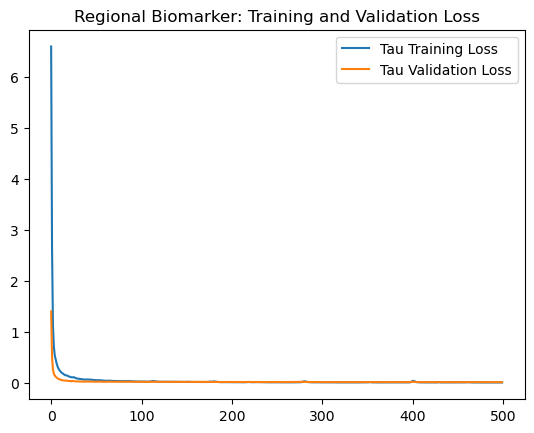

In [48]:
# plot 
import matplotlib.pyplot as plt

plt.plot(tau_train_losses[best_fold - 1], label='Tau Training Loss')
plt.plot(tau_val_losses[best_fold - 1], label='Tau Validation Loss')
plt.title('Regional Biomarker: Training and Validation Loss')
plt.legend()
plt.show()


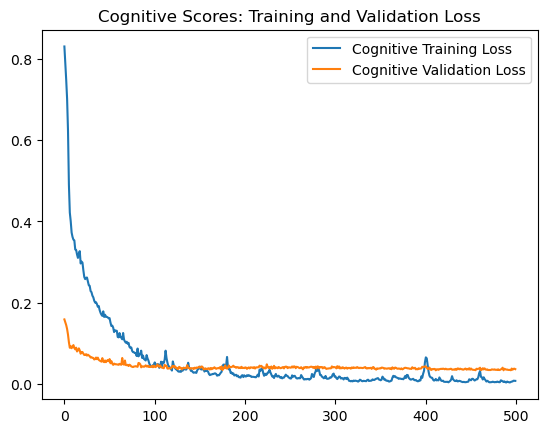

In [49]:
plt.plot(cog_train_losses[best_fold - 1], label='Cognitive Training Loss')
plt.plot(cog_val_losses[best_fold - 1], label='Cognitive Validation Loss')
plt.title('Cognitive Scores: Training and Validation Loss')
plt.legend()
plt.show()



### Evaluate model on test set

In [50]:
# load best model and evaluate on test set
model = LSTMwithStatic(input_dim=8, hidden_dim=128, layer_dim=1, output_dim=86, scalar_output_dim=2, ann_hidden_dims=[128, 64, 32, 16], static_input_dim=13)
model.load_state_dict(torch.load(f'../models/lstm_{best_fold}.pth'))
model.eval()
test_loader = DataLoader(test_dataset, batch_size=32)

# evalute on test set and store predictions
with torch.no_grad():
    tau_predictions = []
    tau_true = []
    cog_predictions = []
    cog_true = []
    for tau, next_step, static, cog, _ in test_loader:
        outputs, scores = model(tau, static)
        tau_predictions.append(outputs)
        tau_true.append(next_step)
        cog_predictions.append(scores)
        cog_true.append(cog)
    

tau_predictions = torch.cat(tau_predictions, dim=0)
tau_true = torch.cat(tau_true, dim=0)
cog_predictions = torch.cat(cog_predictions, dim=0)
cog_true = torch.cat(cog_true, dim=0)


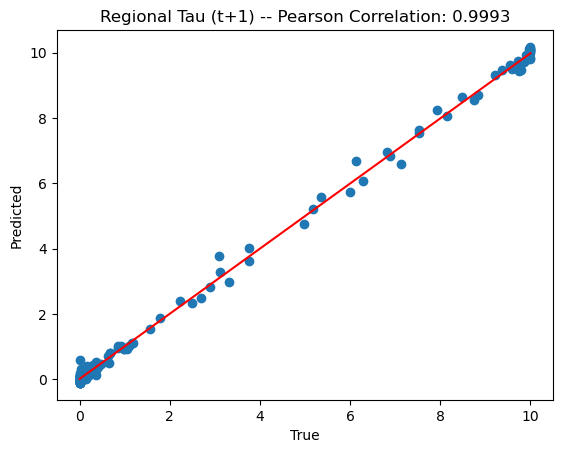

torch.Size([295, 86])

In [51]:
# plot scatter plot
import matplotlib.pyplot as plt


corr = np.corrcoef(tau_predictions[:,17].numpy(), tau_true[:,17].numpy())[0, 1]

plt.scatter(tau_true[:, 17], tau_predictions[:,17])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(np.unique(tau_true[:, 17]), np.poly1d(np.polyfit(tau_true[:, 17], tau_predictions[:,17], 1))(np.unique(tau_true[:, 17])), color='red')
plt.title(f'Regional Tau (t+1) -- Pearson Correlation: {corr:.4f}')
plt.show()

tau_true.shape



In [52]:
# plot
# unnormalize cognitive score
for p in cog_predictions:
    p[0] = p[0] * adas_std + adas_mean
    p[1] = p[1] * mmse_std + mmse_mean

for t in cog_true:
    t[0] = t[0] * adas_std + adas_mean
    t[1] = t[1] * mmse_std + mmse_mean
    



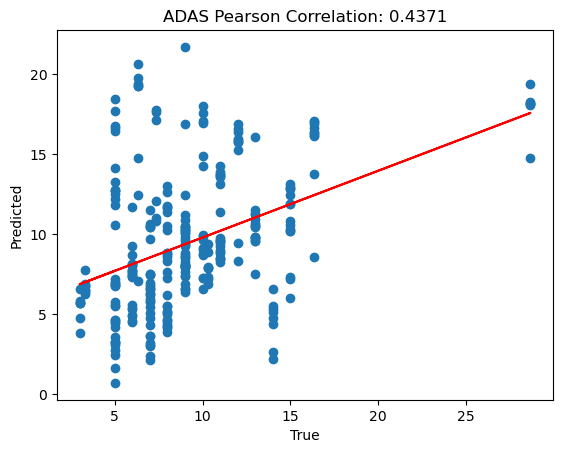

In [53]:
# plot ADAS true vs pred


corr = np.corrcoef(cog_predictions[:,0], cog_true[:,0])[0, 1]

plt.scatter(cog_true[:,0], cog_predictions[:,0])
plt.xlabel('True')
plt.ylabel('Predicted')
m, b = np.polyfit(cog_true[:,0], cog_predictions[:,0], 1)
plt.plot(cog_true[:,0], m*cog_true[:,0] + b, color='red')
plt.title(f'ADAS Pearson Correlation: {corr:.4f}')
plt.show()



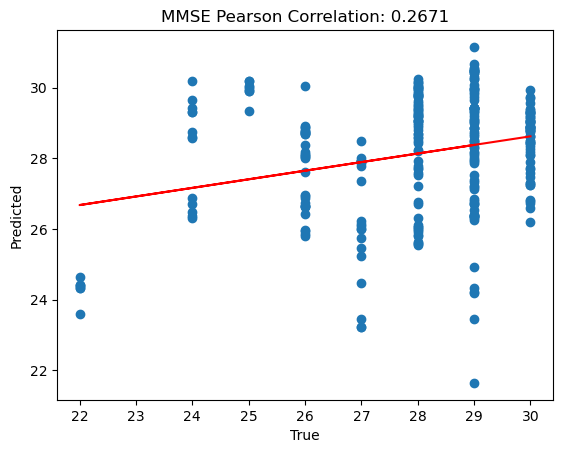

In [54]:
# plot MMSE true vs pred
corr = np.corrcoef(cog_predictions[:,1], cog_true[:,1])[0, 1]

plt.scatter(cog_true[:,1], cog_predictions[:,1])
plt.xlabel('True')
plt.ylabel('Predicted')
m, b = np.polyfit(cog_true[:,1], cog_predictions[:,1], 1)
plt.plot(cog_true[:,1], m*cog_true[:,1] + b, color='red')
plt.title(f'MMSE Pearson Correlation: {corr:.4f}')
plt.show()